#### 自适应控制实验分析

##### 实验准备

In [4]:
# region import
import os,sys
import numpy as np
import joblib
import torch

import matplotlib as mpl
import matplotlib as plt
import matplotlib.pyplot as plt

sys.path.append("../models/")
from uncertainty_surrogate_model import UncertaintySurrogateModel
from mdn_model import mdn_mean,variance,aleatoric_uncertainty,epistemic_uncertainty
sys.path.append("../utils/")
from process import timeloss_process
# endregion

# region configuration
# mpl.rcParams['font.sans-serif']='SimHei'
mpl.rcParams['font.family'] = ['Times New Roman','SimSun'] 
mpl.rcParams['mathtext.fontset'] = 'stix' # 设置数学公式字体为stix
mpl.rcParams['font.size'] = 9  # 按磅数设置的
mpl.rcParams['figure.dpi'] = 300
cm = 1/2.54  # centimeters in inches
mpl.rcParams['figure.figsize'] = (12*cm,8*cm)
mpl.rcParams['savefig.dpi'] = 900
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.grid.axis'] = 'both'
mpl.rcParams['axes.grid.which'] = 'both'
mpl.rcParams['axes.facecolor'] = 'white'
# endregion


In [5]:
# helper function
def aggregate(a,freq,axis,mode='instantaneous'):
    shp = list(a.shape)
    n = shp[axis] - shp[axis]%freq
    shp[axis] = n
    a = np.stack(np.split(a.take(np.arange(n),axis),n/freq,axis),axis)  # (# (...,n/freq,freq,...))
    shp1 = a.shape
    a = a.sum(axis+1,keepdims=True)  # (...,n/freq,1,...)
    if mode == 'cumulative':
        a = a.cumsum(axis)
    a = np.broadcast_to(a,shp1).reshape(shp)
    
    return a

In [21]:
# 导入数据
proposed_name = 'test-ada-webster'
exp_names = ['test-ada-webster','test-mpc']
control_dir = "../results/experiment/control/"

with open(control_dir+proposed_name+'/'+'simulation_data.pkl','rb') as f:
    simulation_data = joblib.load(f)
with open(control_dir+proposed_name+'/'+'timestamp_data.pkl','rb') as f:
    timestamp_data = joblib.load(f)
with open(control_dir+proposed_name+'/'+'mpc_data.pkl','rb') as f:
    mpc_data = joblib.load(f)

simulation_dataset = {}
timestamp_dataset = {}
mpc_dataset = {}
for name in exp_names:
    with open(control_dir+name+'/'+'simulation_data.pkl','rb') as f:
        simulation_dataset[name] = joblib.load(f)
    with open(control_dir+name+'/'+'timestamp_data.pkl','rb') as f:
        timestamp_dataset[name] = joblib.load(f)
    with open(control_dir+name+'/'+'mpc_data.pkl','rb') as f:
        mpc_dataset[name] = joblib.load(f)

# region
# simulation_data: dict of tc,arrive,queue_length,timeloss,depart
#   tc: list of array(13)
#   arrive: list of array(frame_num,4,3)
#   queue_length: list of array(frame_num,4,3)
#   timeloss: list of array(frame_num,4,3)
#   depart: list of array(frame_num,4,3)
# timestamp_data: 开始控制后每个周期结束的时间点，以monitor启动的时刻为零点,list
# mpc_data: surrogate_result, control_result, upper_context, surrogate_model
#   surrogate_result: list of tensor tuple, (c,mu,sigma)
#       c: (lookahead,num_components,1)
#       mu: (lookahead,num_components,1)
#       sigma: (lookahead,num_components,1)
    
#   control_result: list of tensor of shape (lookahead,13)
#   surrogate_model: simply neural network model
# endregion

##### 控制效果分析

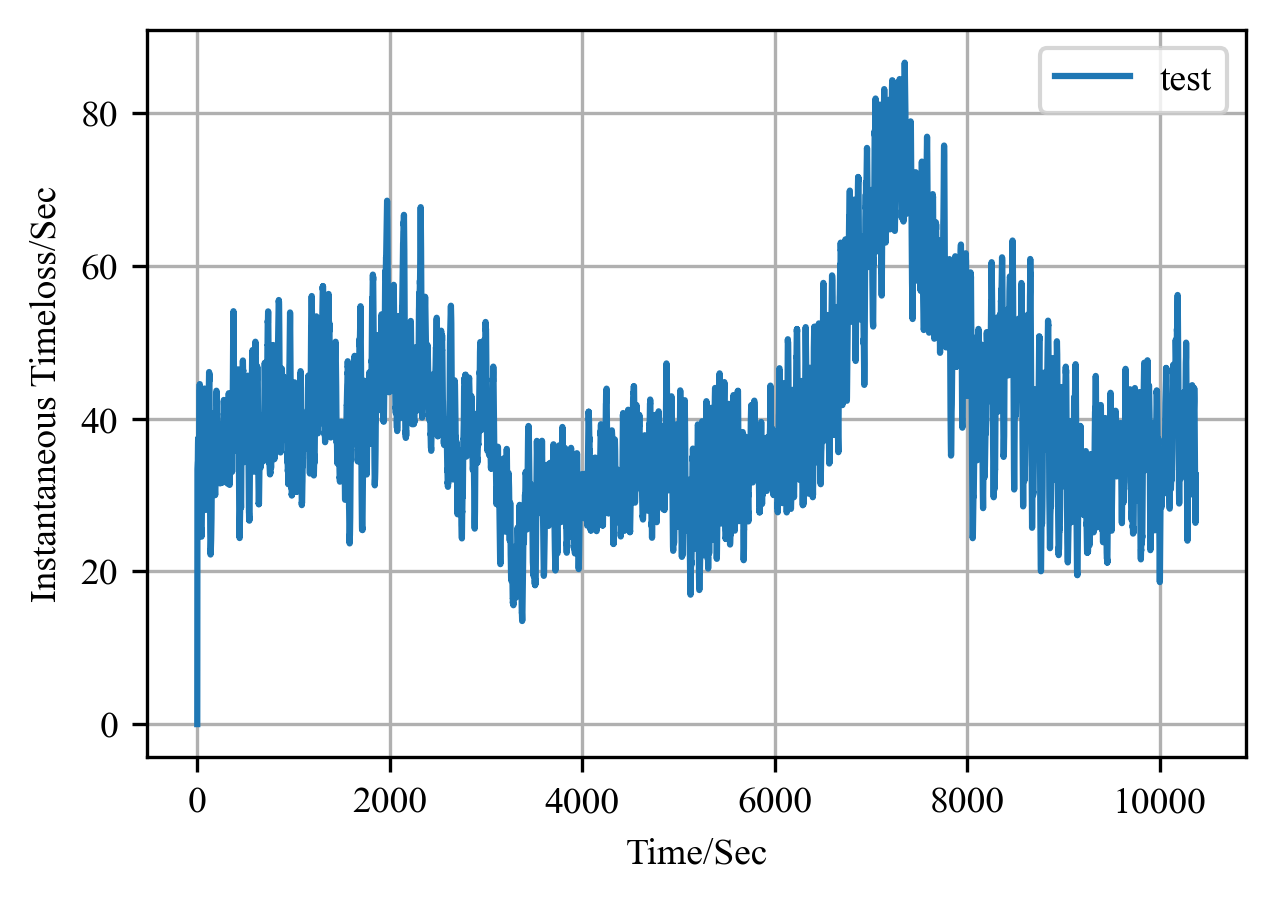

In [6]:
# 瞬时延误
fig,ax = plt.subplots()
ax.plot(np.concatenate(simulation_data['timeloss'],axis=0).sum(axis=(-1,-2)),label='test')
ax.set_xlabel('Time/Sec')
ax.set_ylabel('Instantaneous Timeloss/Sec')
ax.legend()
# fig.savefig(control+'delay_plot.jpg',bbox_inches='tight')


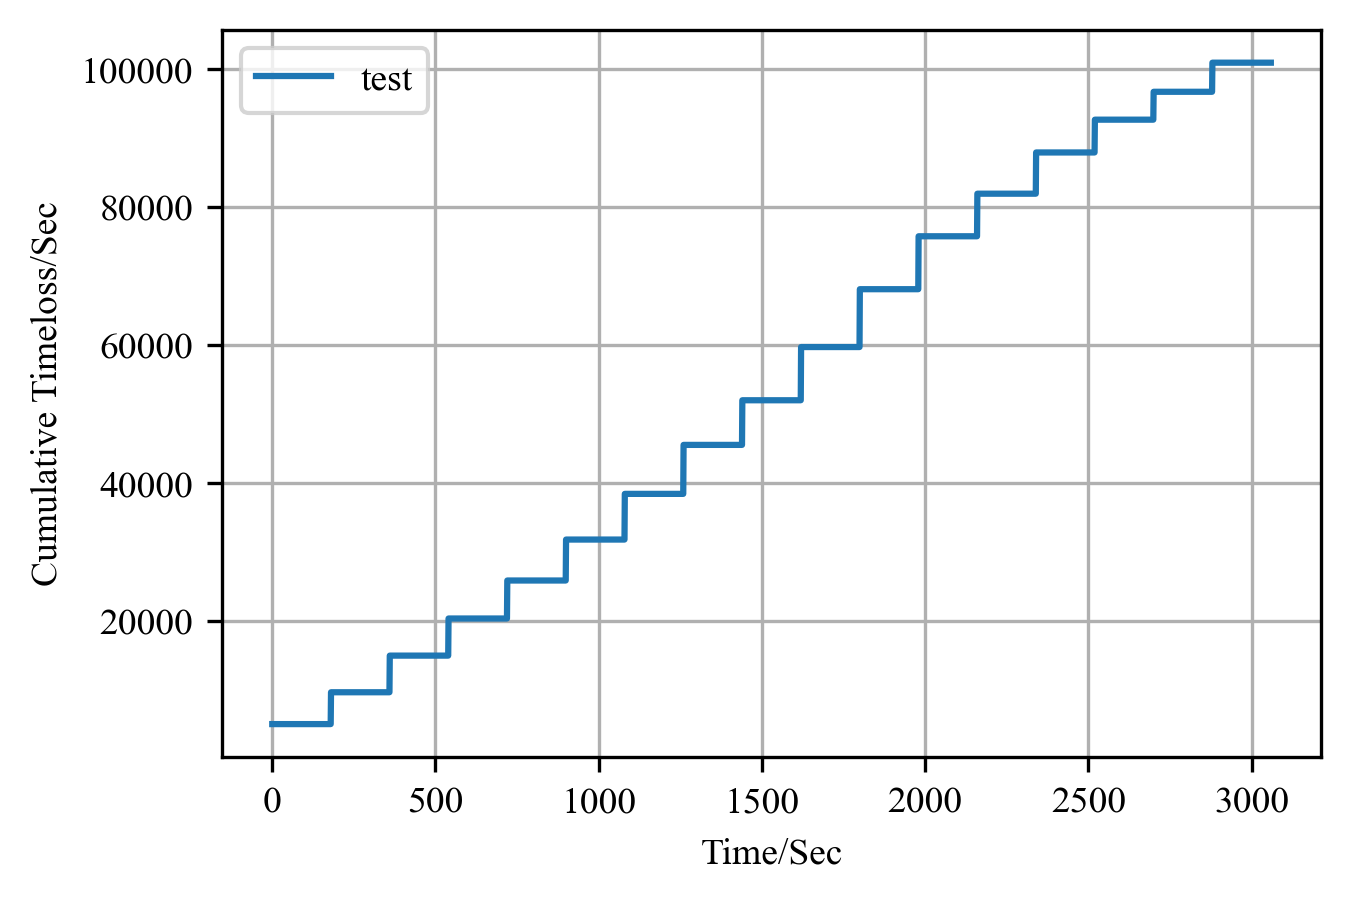

In [6]:
# 累计延误
fig,ax = plt.subplots()
x = np.concatenate(simulation_data['timeloss'],axis=0).sum(axis=(-1,-2))
x = aggregate(x,180,0,'cumulative')
ax.plot(x,label='test')
ax.set_xlabel('Time/Sec')
ax.set_ylabel('Cumulative Timeloss/Sec')
ax.legend()
# fig.savefig(control+'delay_plot.jpg',bbox_inches='tight')

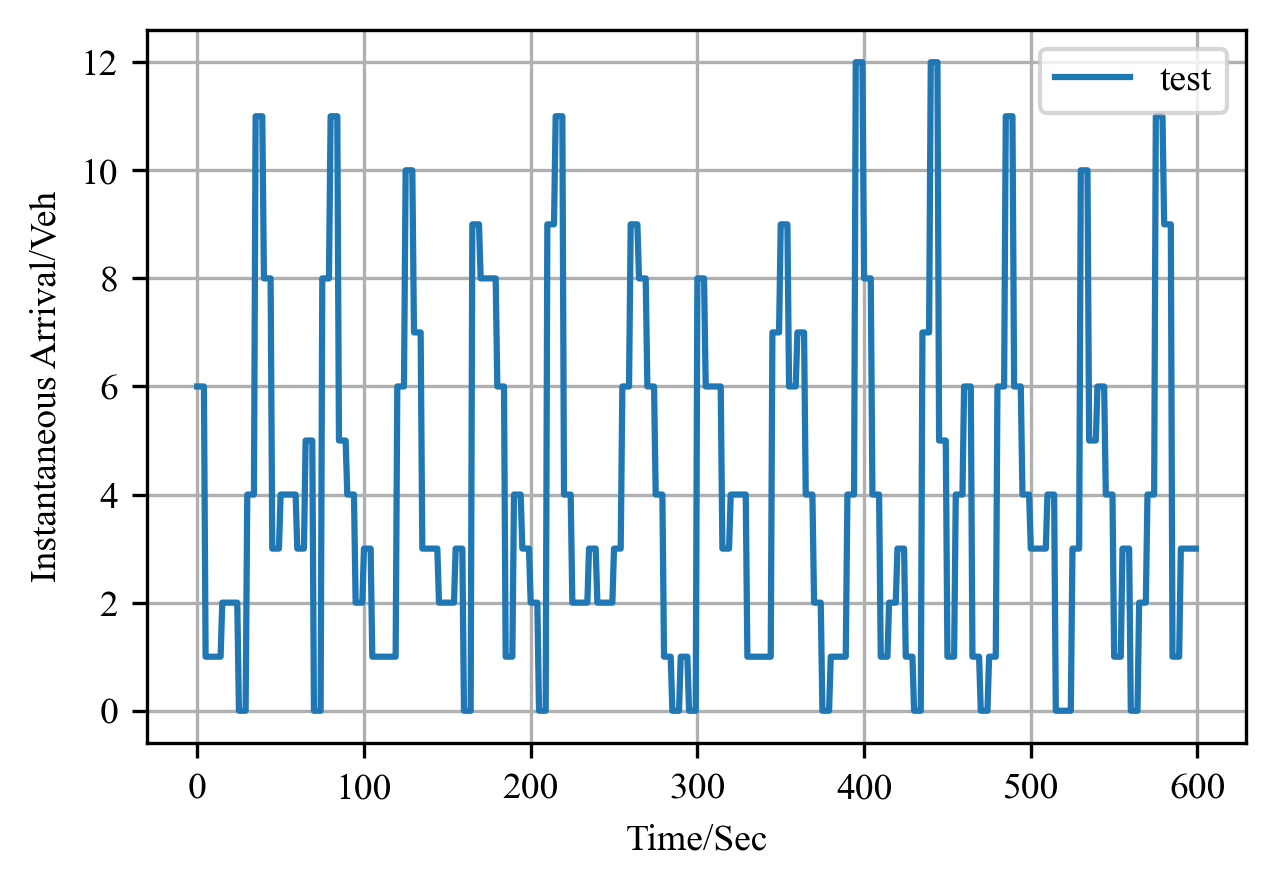

In [6]:
# 瞬时到达
fig,ax = plt.subplots()
x = np.concatenate(simulation_data['arrive'],axis=0).sum(axis=(-1,-2))[1800:2400]
x = aggregate(x,5,0)  # aggregate interval
ax.plot(x,label='test')
ax.set_xlabel('Time/Sec')
ax.set_ylabel('Instantaneous Arrival/Veh')
ax.legend()
# fig.savefig(control+'delay_plot.jpg',bbox_inches='tight')

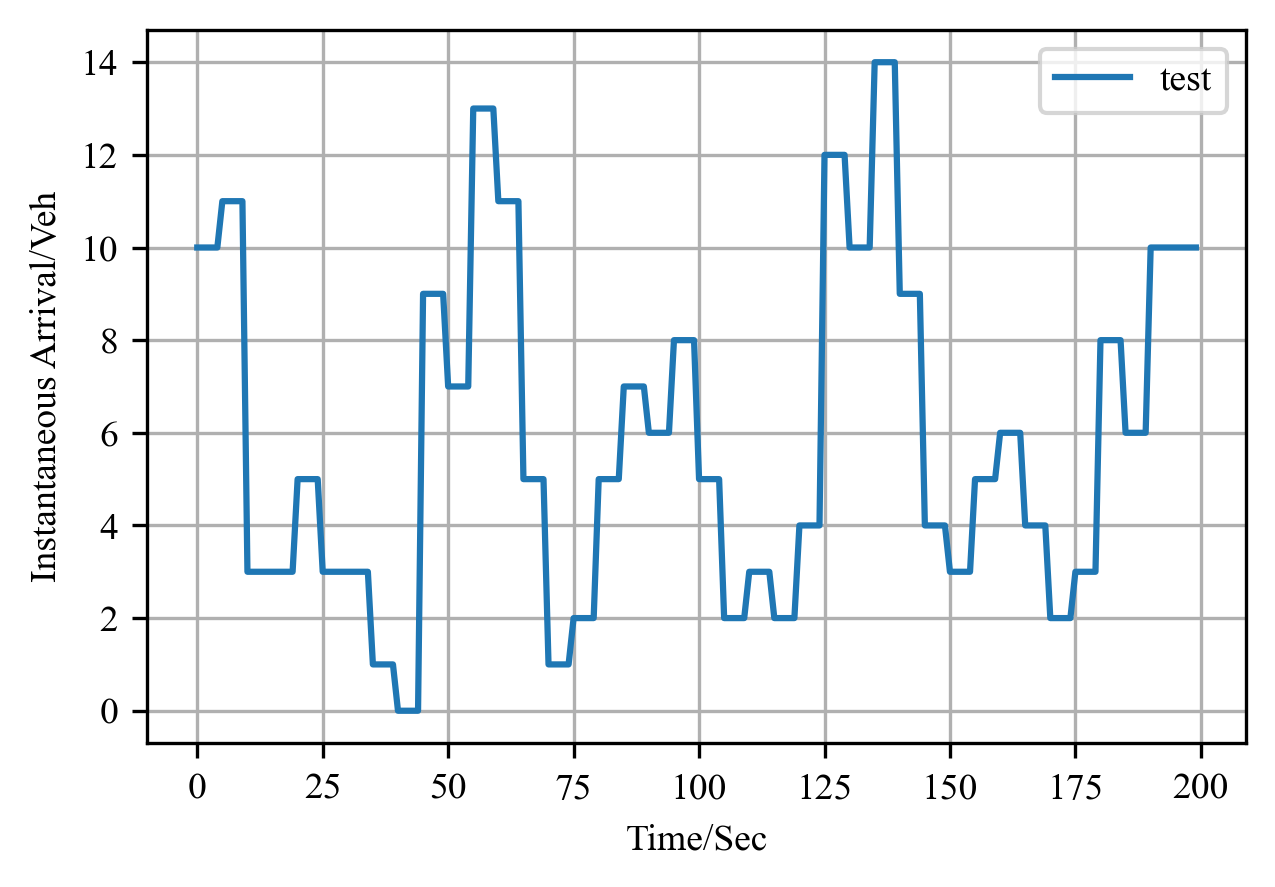

In [45]:
# 瞬时离去
fig,ax = plt.subplots()
x = np.concatenate(simulation_data['depart'],axis=0).sum(axis=(-1,-2))[1000:1200]
x = aggregate(x,5,0)  # aggregate interval
ax.plot(x,label='test')
ax.set_xlabel('Time/Sec')
ax.set_ylabel('Instantaneous Arrival/Veh')
ax.legend()
# fig.savefig(control+'delay_plot.jpg',bbox_inches='tight')

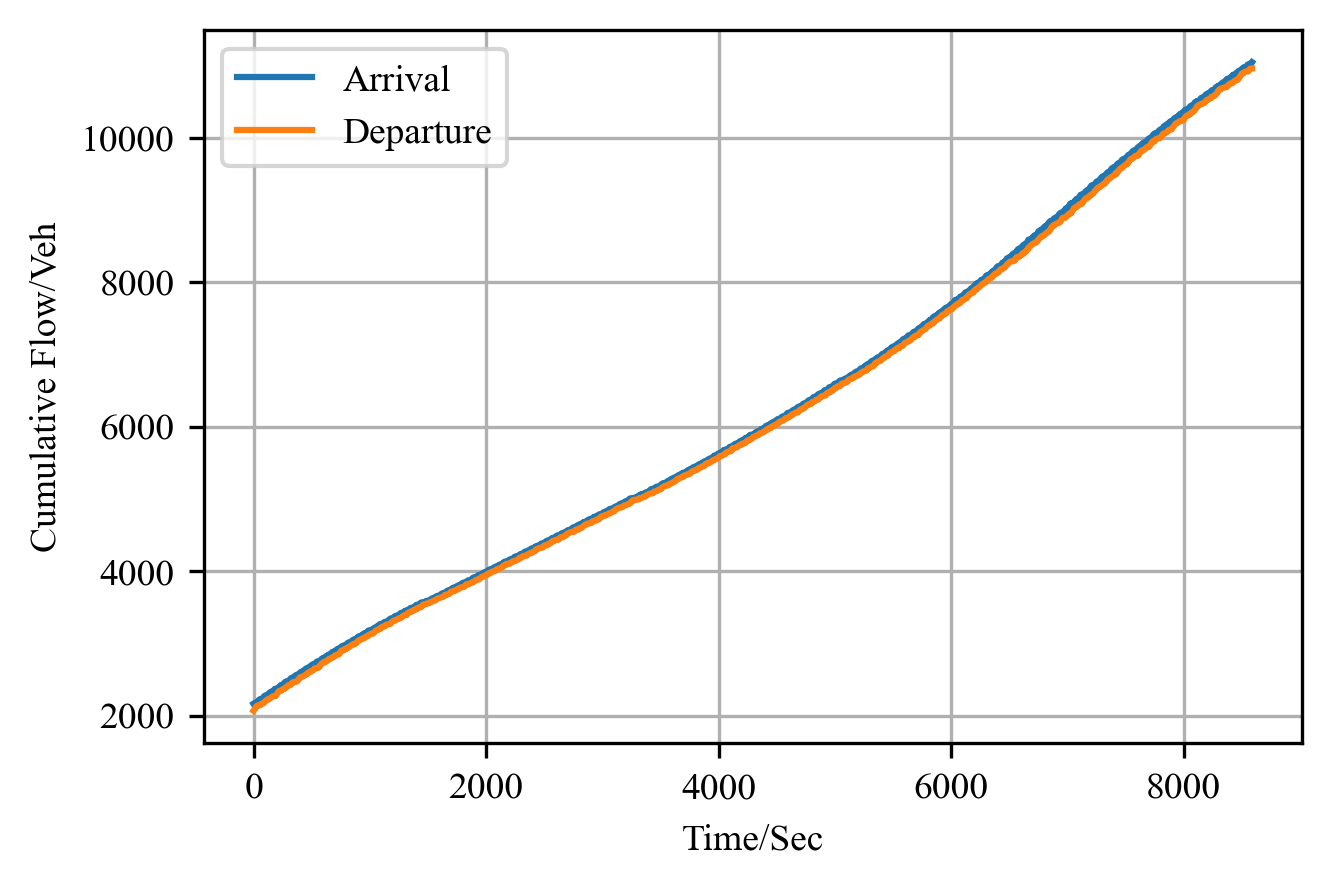

In [46]:
# 到达离去曲线
fig,ax = plt.subplots()
x = np.concatenate(simulation_data['arrive'],axis=0).sum(axis=(-1,-2)).cumsum()
x = x[1800:]
ax.plot(x,label='Arrival')
x = np.concatenate(simulation_data['depart'],axis=0).sum(axis=(-1,-2)).cumsum()
x = x[1800:]
ax.plot(x,label='Departure')
ax.set_xlabel('Time/Sec')
ax.set_ylabel('Cumulative Flow/Veh')
ax.legend()
# fig.savefig(control+'delay_plot.jpg',bbox_inches='tight')

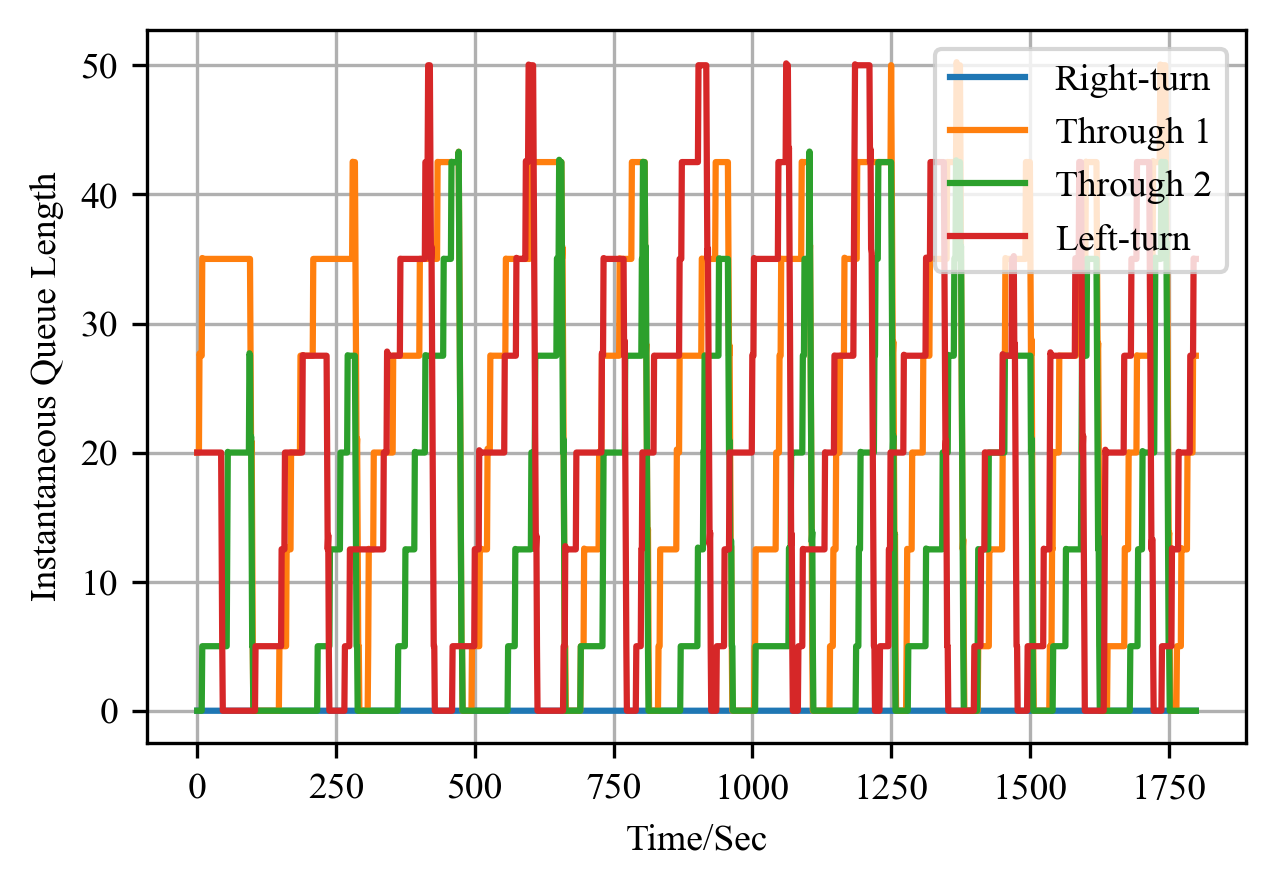

In [47]:
# 瞬时排队
fig,ax = plt.subplots()
interval = np.arange(1800,3600)
ax.plot(np.concatenate(simulation_data['queue_length'],axis=0)[interval,0],label='Right-turn')  # 结果截取，选择车道
ax.plot(np.concatenate(simulation_data['queue_length'],axis=0)[interval,1],label='Through 1')  # 结果截取，选择车道
ax.plot(np.concatenate(simulation_data['queue_length'],axis=0)[interval,2],label='Through 2')  # 结果截取，选择车道
ax.plot(np.concatenate(simulation_data['queue_length'],axis=0)[interval,3],label='Left-turn')  # 结果截取，选择车道
ax.set_xlabel('Time/Sec')
ax.set_ylabel('Instantaneous Queue Length')
ax.legend()
# fig.savefig(control+'delay_plot.jpg',bbox_inches='tight')

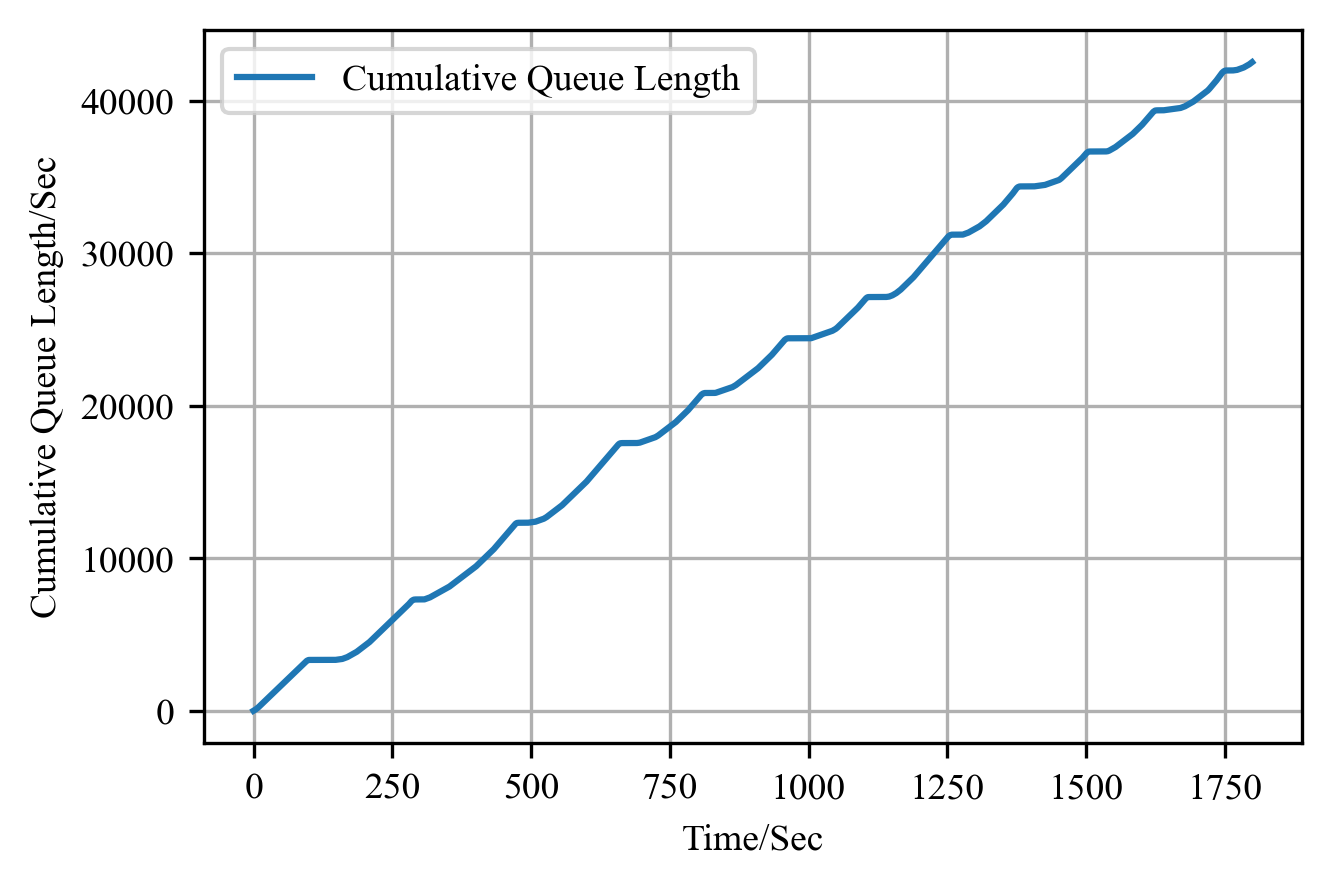

In [48]:
# 累计排队
fig,ax = plt.subplots()
x = np.concatenate(simulation_data['queue_length'],axis=0)[interval,1].cumsum()
ax.plot(x,label='Cumulative Queue Length')
ax.set_xlabel('Time/Sec')
ax.set_ylabel('Cumulative Queue Length/Sec')
ax.legend()
# fig.savefig(control+'delay_plot.jpg',bbox_inches='tight')

##### 控制方案分析

In [49]:
# mpc_data处理
surrogate_result = mpc_data['surrogate_result']
control_result = mpc_data['control_result']
surrogate_model = mpc_data['surrogate_model']

IndexError: index 1 is out of bounds for dimension 0 with size 1

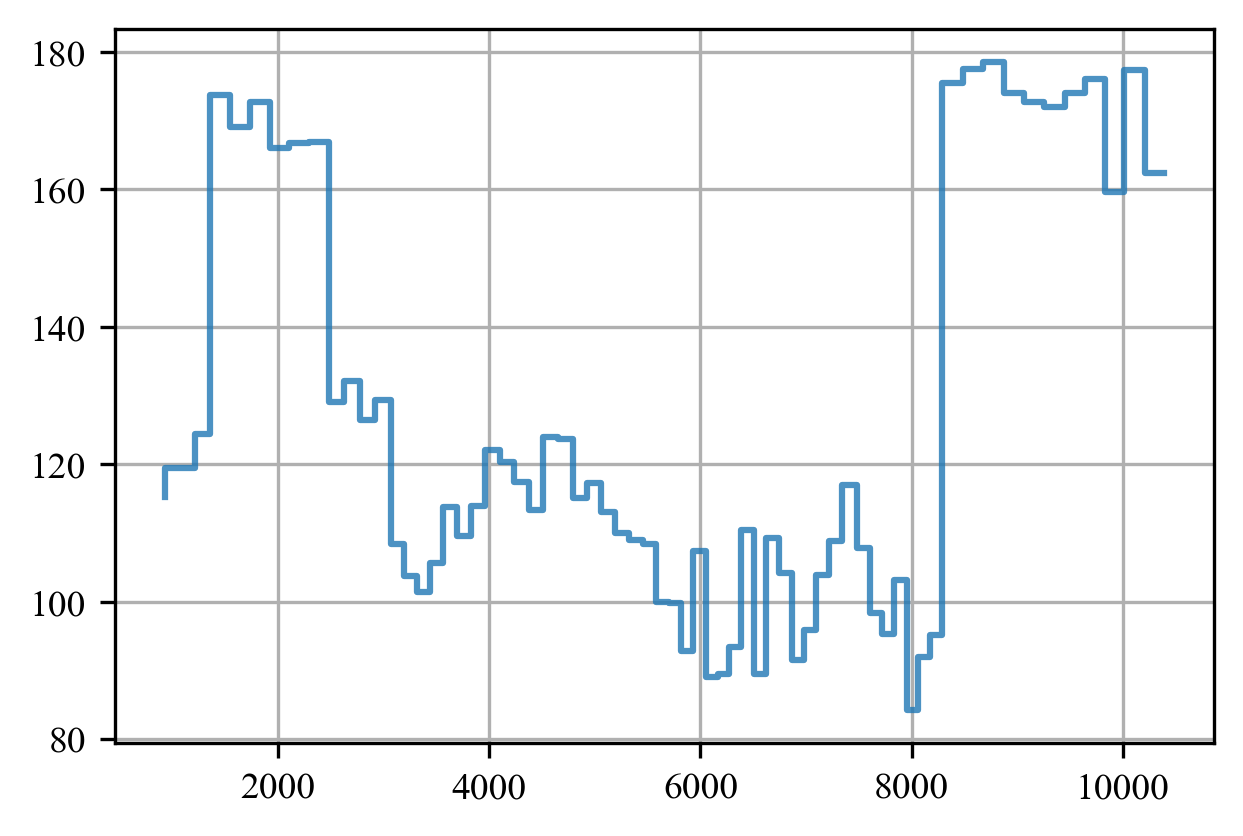

In [50]:
# 规划周期长度
fig,ax = plt.subplots()
for l in range(4):
    x = [res[l,5:].sum(-1)*0.5 for res in mpc_data['control_result']]
    ax.step(timestamp_data[8+l:],x[:-(1+l)],alpha=0.8,label=f'{l+1}-step-ahead')
ax.set_xlabel('Time/Sec')
ax.set_ylabel('Cycle Time/Sec')
ax.legend()

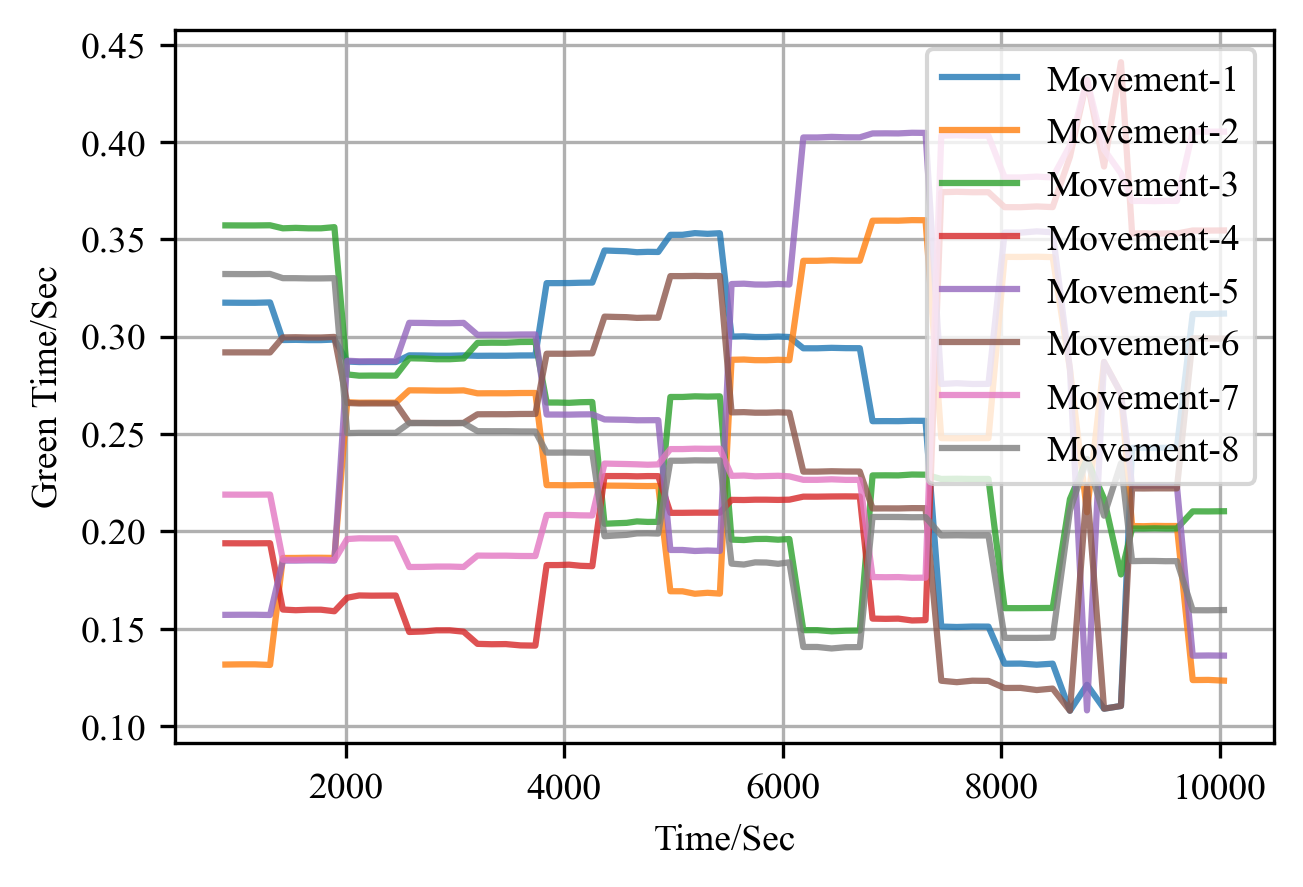

In [129]:
# 绿灯时间
fig,ax = plt.subplots()
l = 0  # lookahead
for i in range(8):
    x = [res[l,5+i]/(res[l,5:].sum(-1)*0.5) for res in mpc_data['control_result']]  # 绿信比
    ax.plot(timestamp_data[8+l:],x[:-(1+l)],alpha=0.8,label=f'Movement-{i+1}')
ax.set_xlabel('Time/Sec')
ax.set_ylabel('Green Time/Sec')
ax.legend()

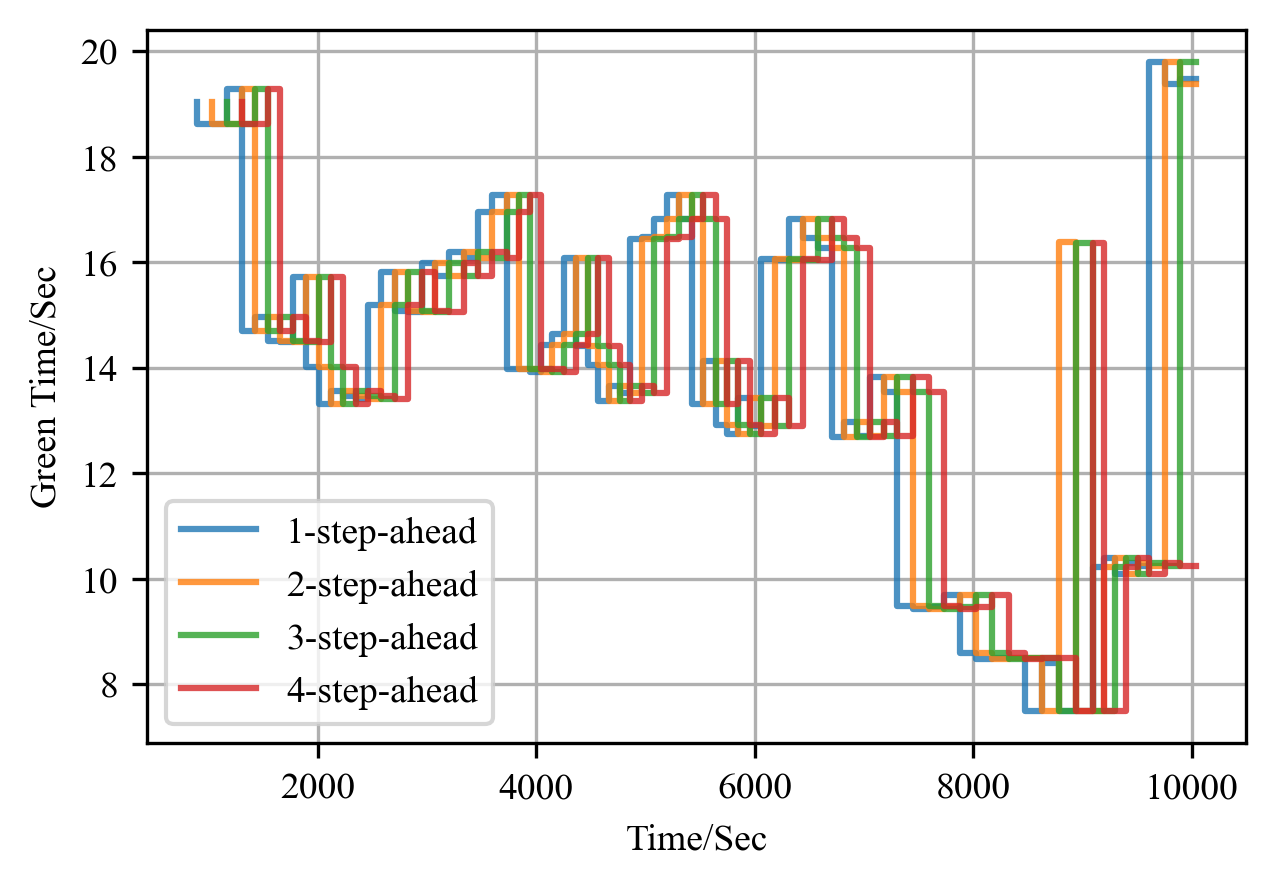

In [130]:
# 规划绿灯时间
fig,ax = plt.subplots()
i = 0  # 绿灯时间下标
for l in range(4):
    x = [res[l,5+i]*0.5 for res in mpc_data['control_result']]
    ax.step(timestamp_data[8+l:],x[:-(1+l)],alpha=0.8,label=f'{l+1}-step-ahead')
ax.set_xlabel('Time/Sec')
ax.set_ylabel('Green Time/Sec')
ax.legend()

##### 控制效果对比

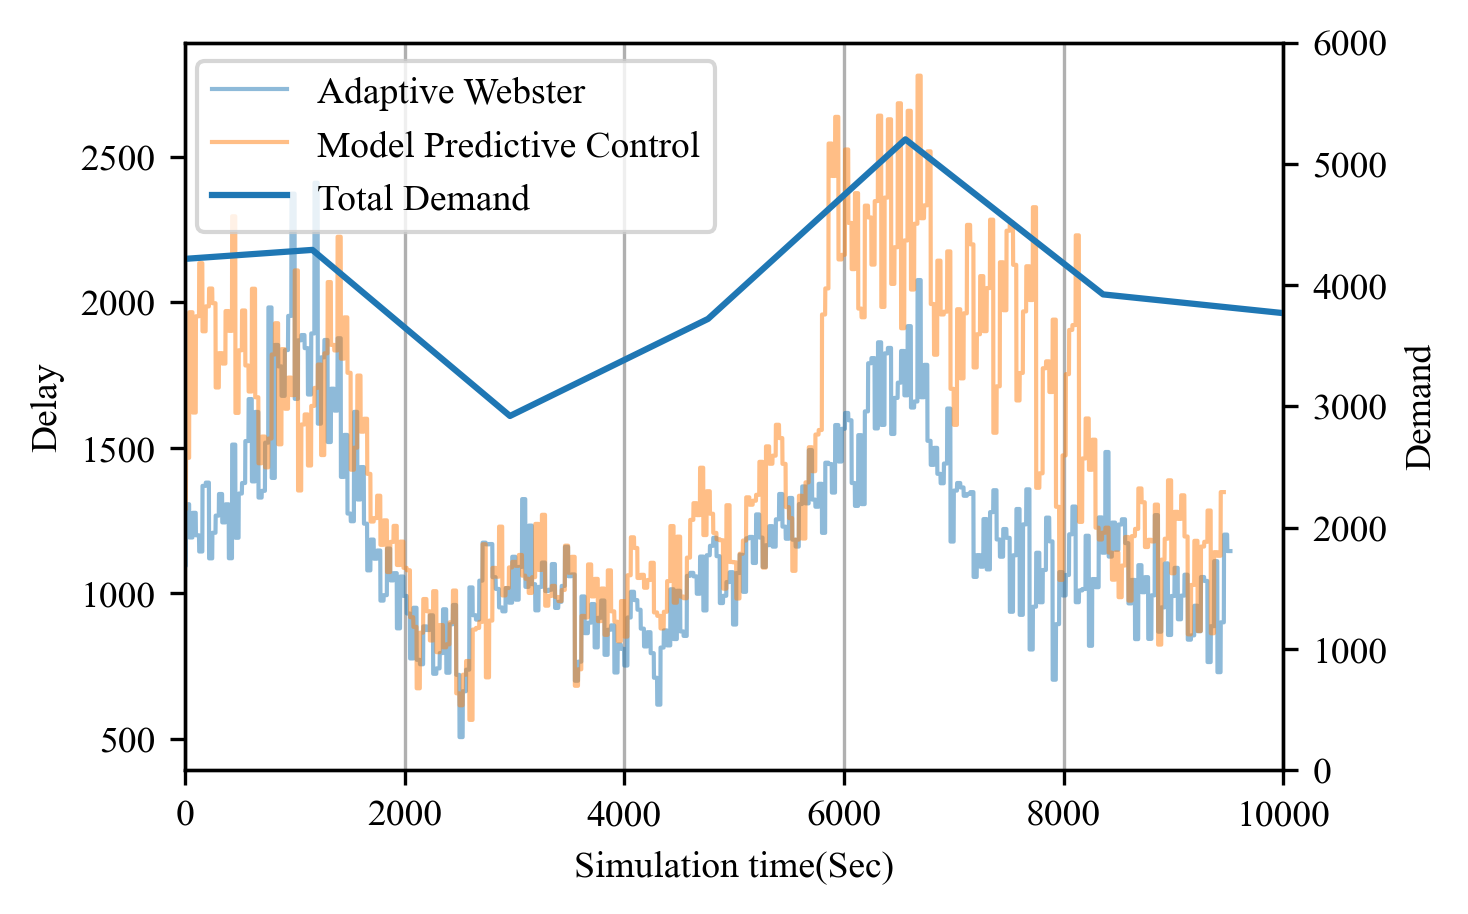

In [24]:
# 瞬时延误
fig,ax = plt.subplots()
for name in exp_names:
    
    x = np.concatenate(simulation_dataset[name]['timeloss'],axis=0).sum(axis=(-1,-2))
    x = aggregate(x,30,0)[800:]
    if name == 'test-ada-webster':
        ax.plot(x,alpha=0.5,label='Adaptive Webster',linewidth=1.0)
    elif name == 'test-mpc':
        ax.plot(x,alpha=0.5,label='Model Predictive Control',linewidth=1.0)
ax.set_xlabel('Simulation time(Sec)')
ax.set_ylabel('Delay')
ax.grid(axis='y')
ax.set_xlim([0,10000])

ax1 = ax.twinx()
x = mpc_data['demand'].sum((-1,-2))
ax1.plot(x,label='Total Demand')
ax1.grid(axis='y')
ax1.set_ylabel('Demand')
ax1.set_ylim([0,6000])

fig.legend(loc=1,bbox_to_anchor=(0.5,1), bbox_transform=ax.transAxes)

fig.savefig(control_dir+'/delay_comparison.jpg',bbox_inches='tight')

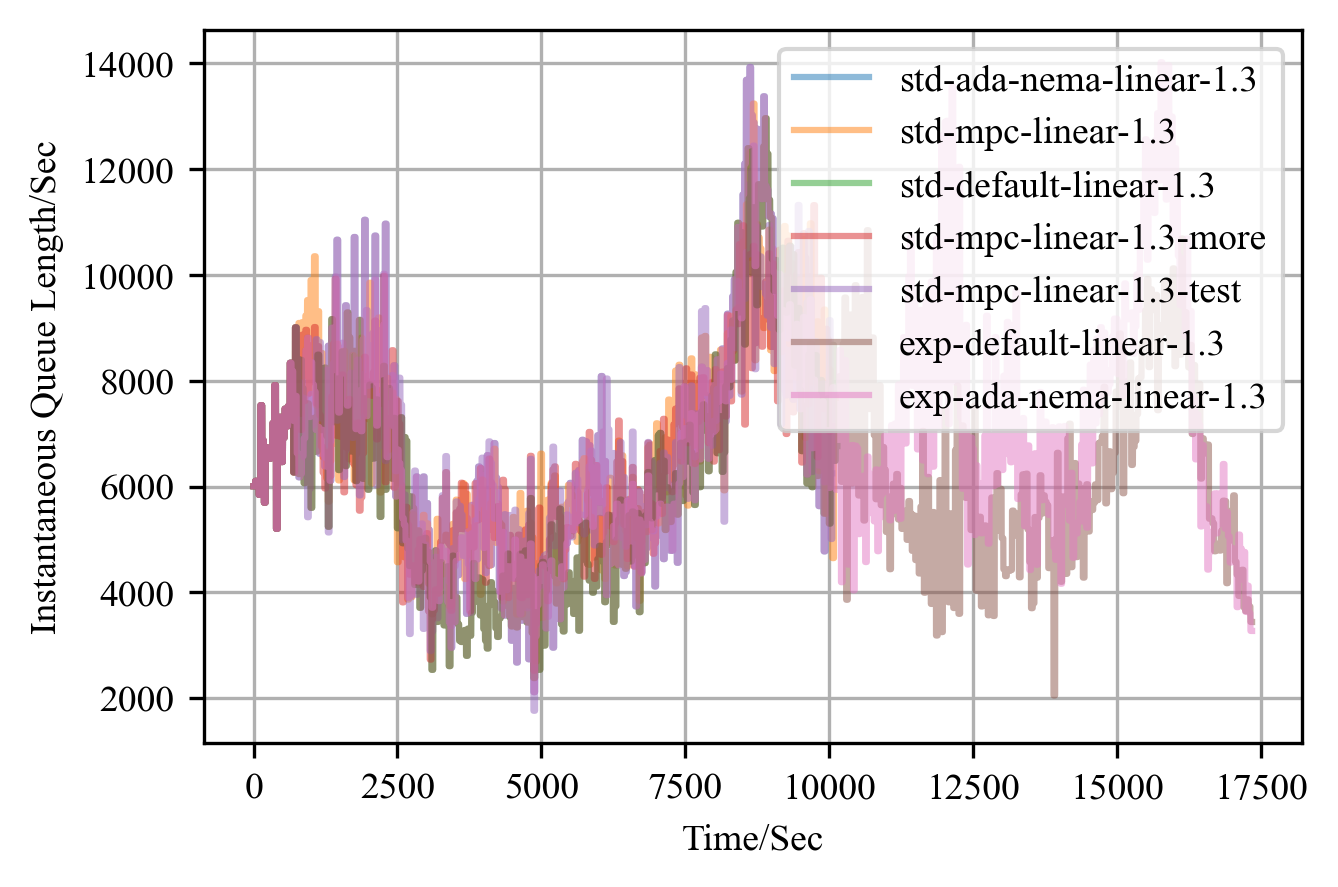

In [97]:
# 瞬时总排队
fig,ax = plt.subplots()
for name in exp_names:
    x = np.concatenate(simulation_dataset[name]['queue_length'],axis=0).sum(-1)# [:,1]
    x = aggregate(x,30,0)[0:]
    ax.plot(x,alpha=0.5,label=name)
ax.set_xlabel('Time/Sec')
ax.set_ylabel('Instantaneous Queue Length/Sec')
ax.legend()
# fig.savefig(control+'delay_plot.jpg',bbox_inches='tight')

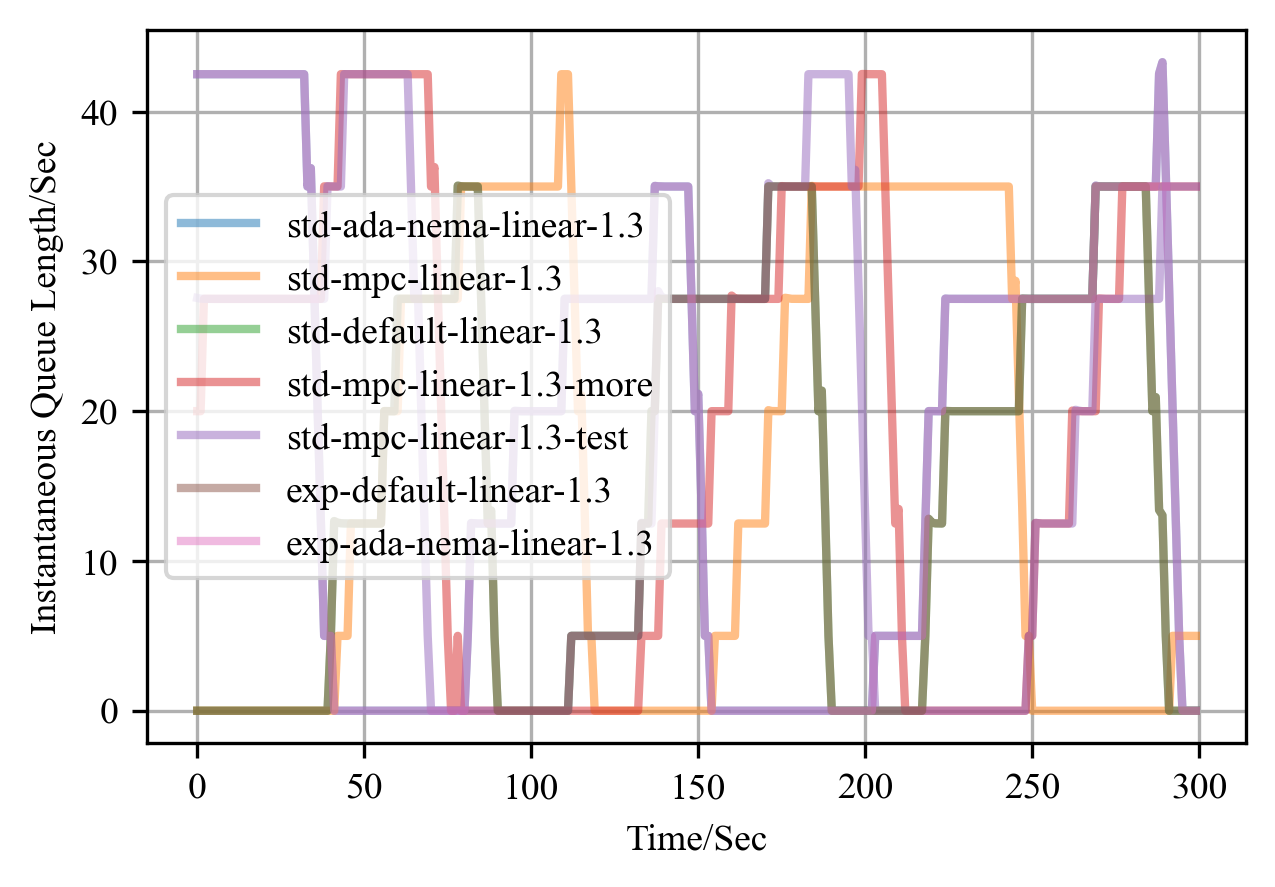

In [90]:
# 瞬时车道排队
fig,ax = plt.subplots()
for name in exp_names:
    x = np.concatenate(simulation_dataset[name]['queue_length'],axis=0)[:,5]
    x = aggregate(x,1,0)[3600:3900]
    ax.plot(x,alpha=0.5,label=name,linewidth=2.0)
ax.set_xlabel('Time/Sec')
ax.set_ylabel('Instantaneous Queue Length/Sec')
ax.legend()
# fig.savefig(control+'delay_plot.jpg',bbox_inches='tight')

In [66]:
# 车均延误

for name in exp_names:
    # print(len(simulation_dataset[name]['timeloss']))
    total_timeloss = np.concatenate(simulation_dataset[name]['timeloss'][8:],axis=0).sum()
    total_depart = np.concatenate(simulation_dataset[name]['depart'][8:],axis=0).sum()
    print(name,total_timeloss,total_depart,total_timeloss/total_depart)


test-ada-nema 363784.68533408147 9954.0 36.546582814354174
test-ada-nema-revised 359876.9428034887 9969.0 36.09960304980326
test-mpc-revised 427590.54195725993 10029.0 42.635411502369124
test-mpc-revised-revised 424026.13172151655 10029.0 42.28000116876225


##### 控制方案对比

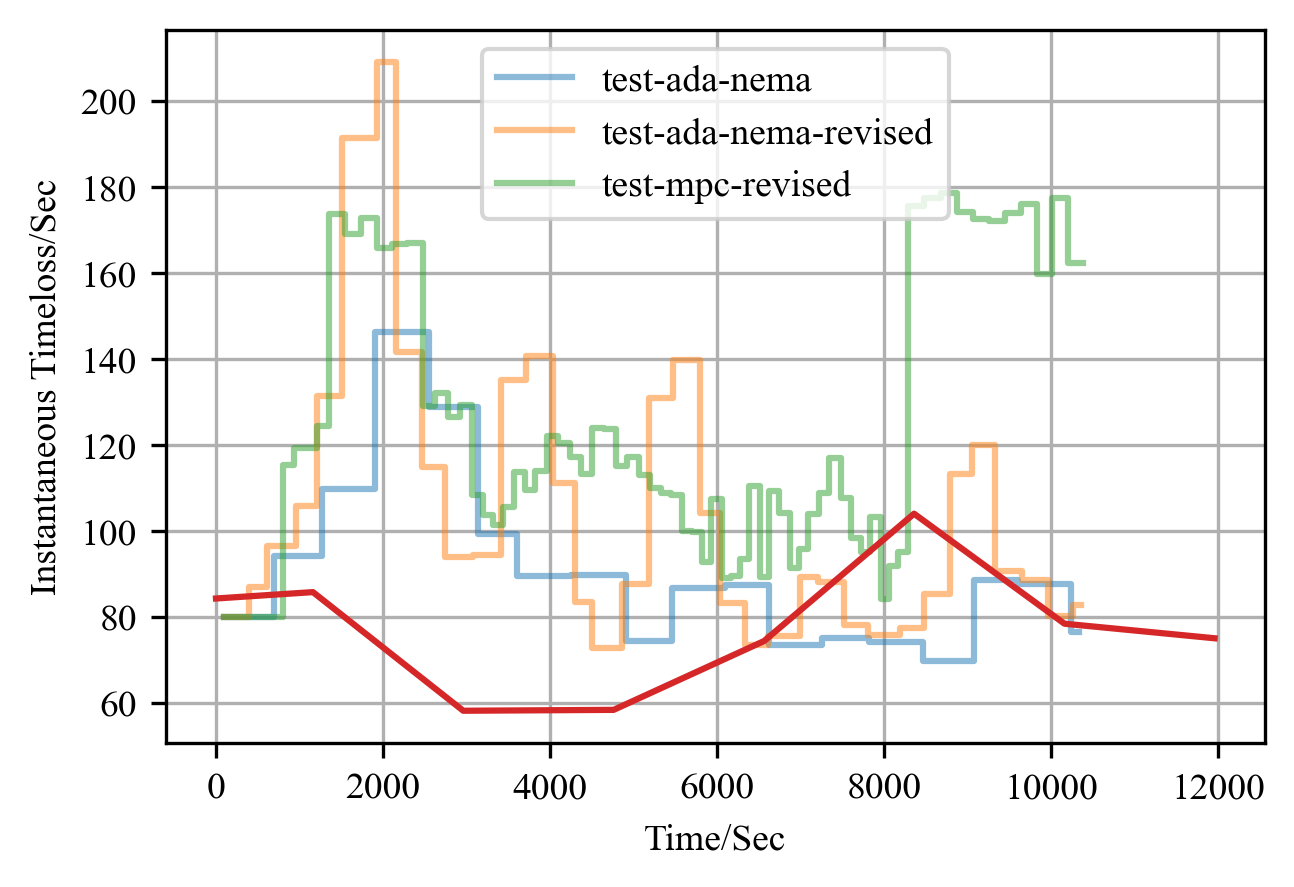

In [64]:
# 周期长度
fig,ax = plt.subplots()
for name in exp_names:
    x = timestamp_dataset[name]
    split = np.stack([c['split'] for c in simulation_dataset[name]['tc']],axis=0)
    y = split.sum(-1)*0.5
    ax.step(x,y,alpha=0.5,label=name)

ax.set_xlabel('Time/Sec')
ax.set_ylabel('Instantaneous Timeloss/Sec')
ax.legend()

x = mpc_data['demand'].sum((-1,-2))
x = aggregate(x,1,0)/50
ax.plot(x,label='demand')
# fig.savefig(control+'delay_plot.jpg',bbox_inches='tight')

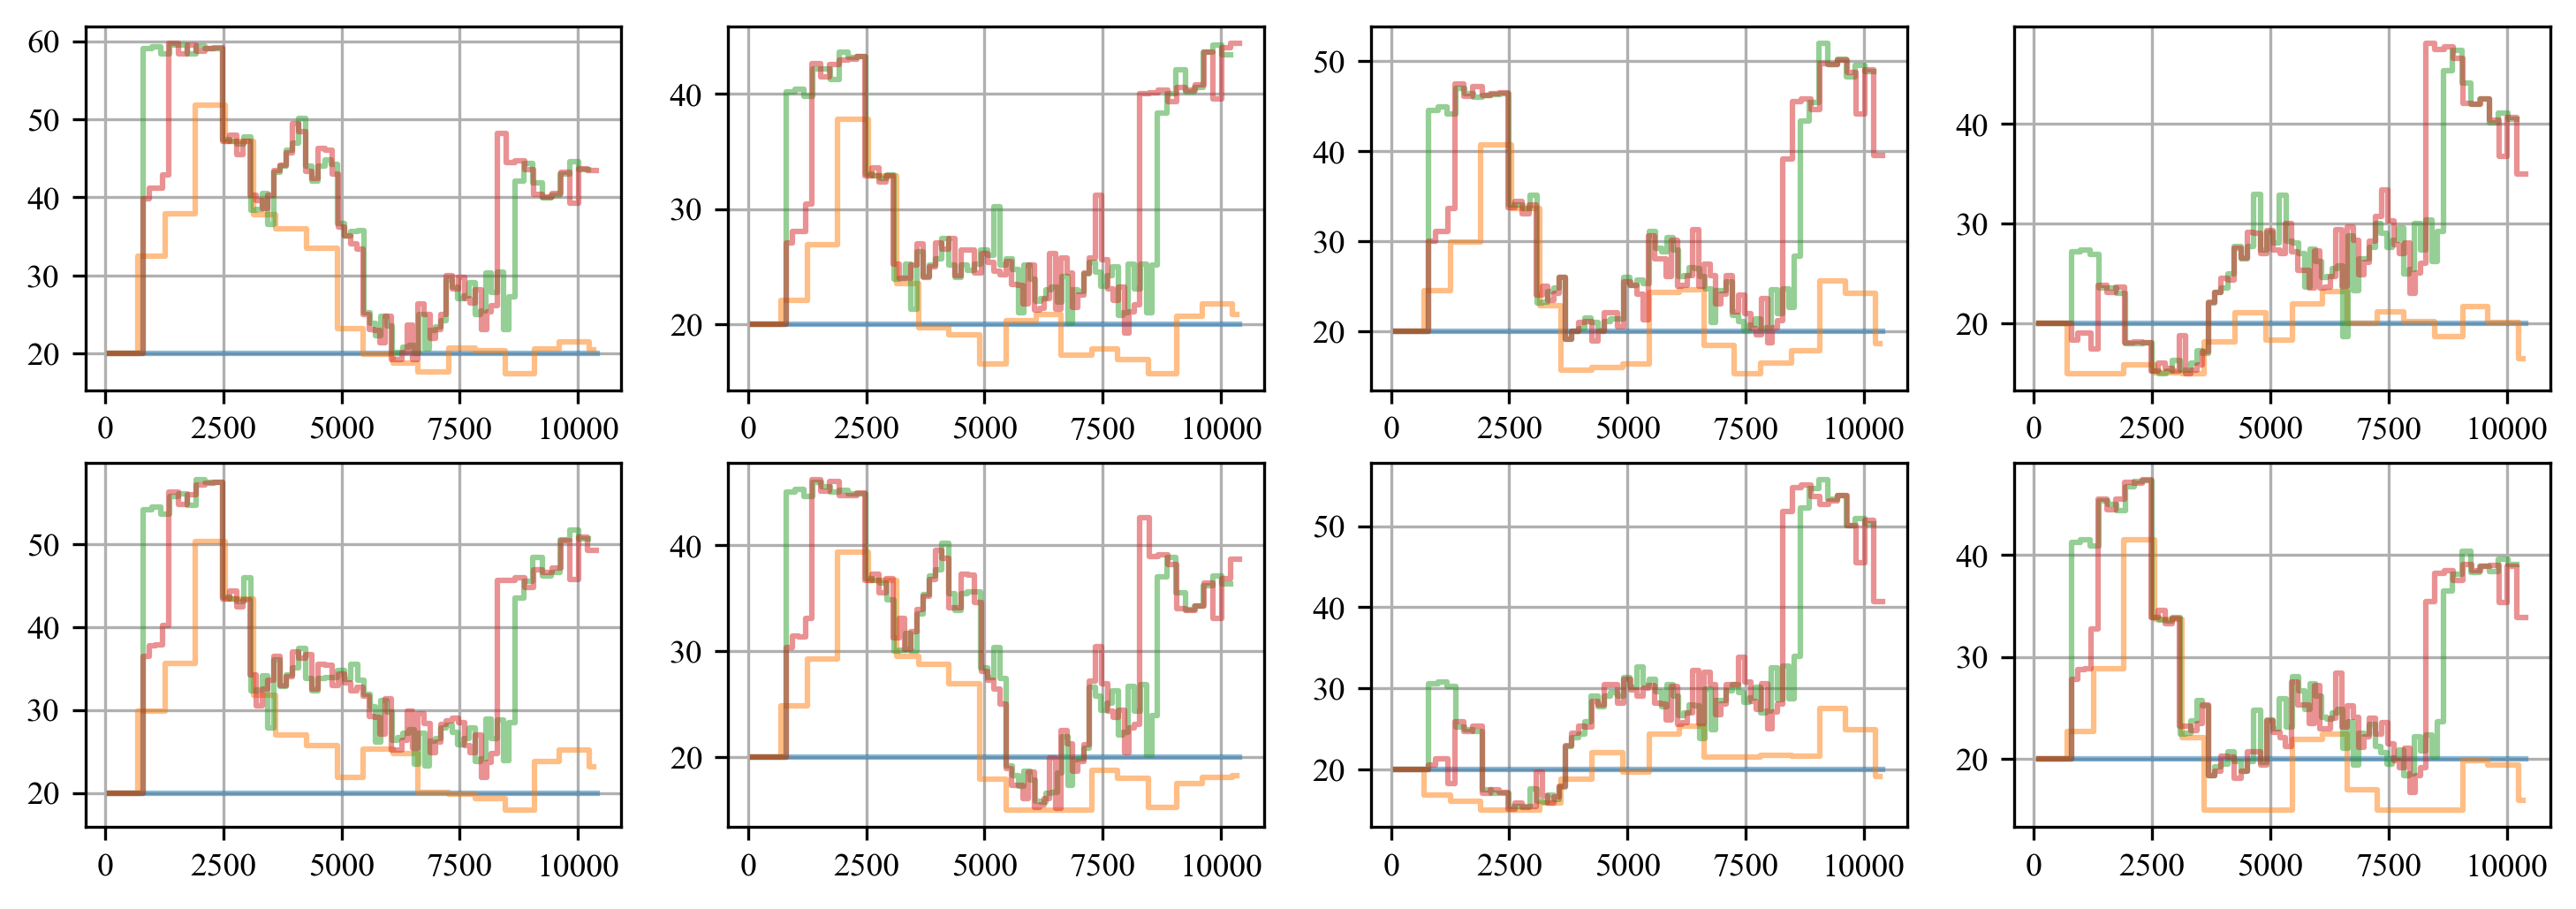

In [52]:
# 绿灯时间长度
fig,axs = plt.subplots(2,4)
fig.set_size_inches(12,4)
for name in exp_names:
    x = timestamp_dataset[name]
    tc = np.stack([c['split'] for c in simulation_dataset[name]['tc']],axis=0)
    for i in range(8):
        axs[i//4,i%4].step(x,tc[:,i],alpha=0.5,label=name)
# axs[i//4,i%4].legend()
# fig.savefig(control+'delay_plot.jpg',bbox_inches='tight')

##### 仿真需求分析

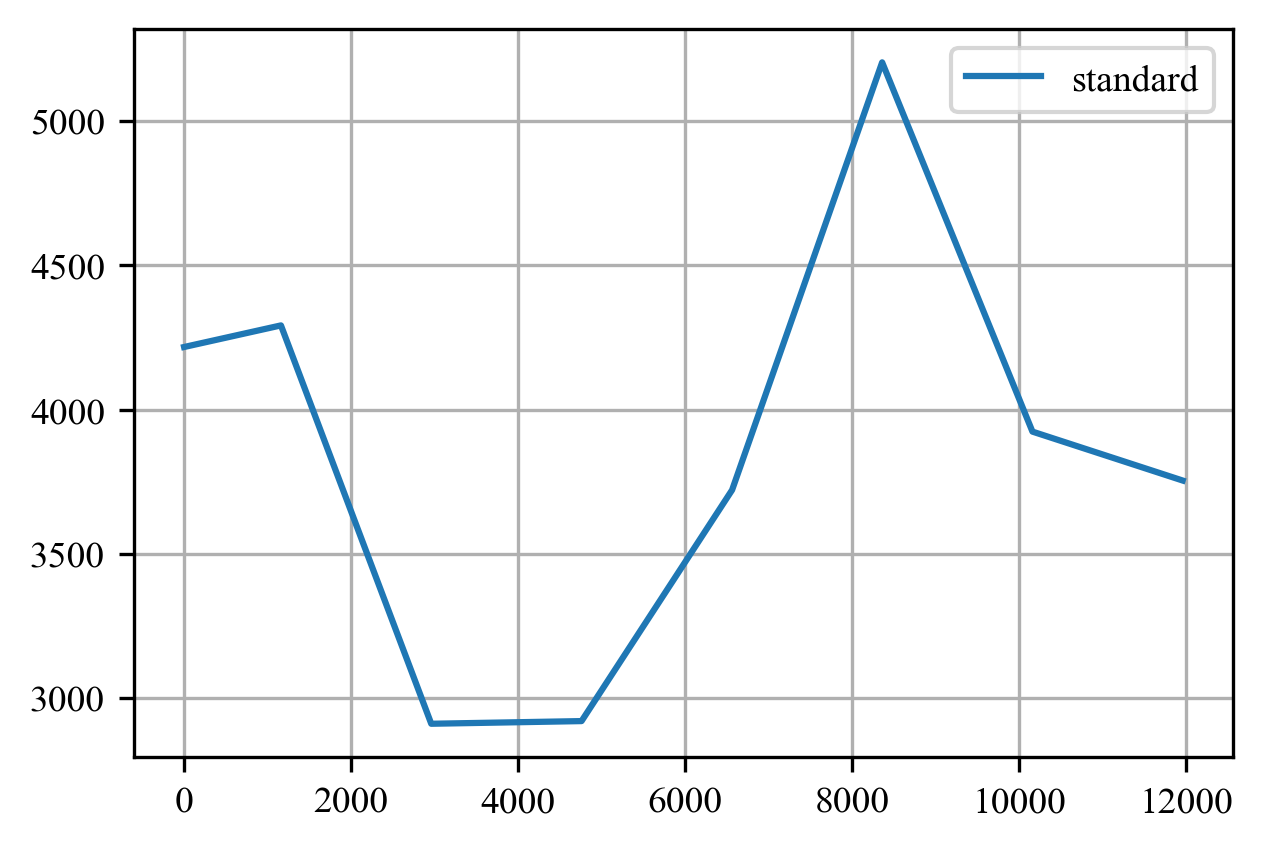

In [12]:
# 需求统一检查
fig,ax = plt.subplots()
for name in exp_names:
    x = mpc_dataset[name]['demand'].sum((-1,-2))
    x = aggregate(x,1,0)
    ax.plot(x,label=name)
ax.legend()

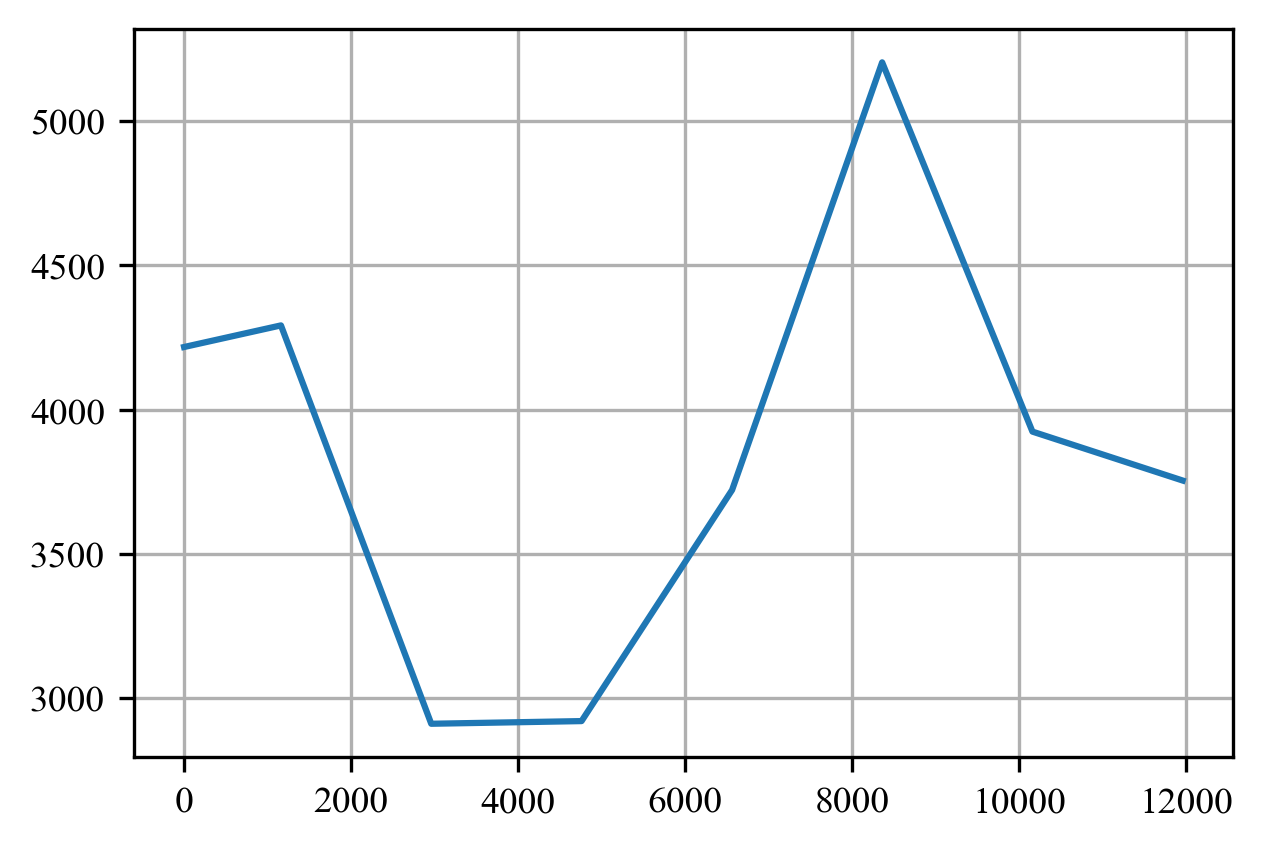

In [14]:
# 总需求曲线
fig,ax = plt.subplots()
x = mpc_data['demand'].sum((-1,-2))
x = aggregate(x,1,0)
ax.plot(x,label='demand')

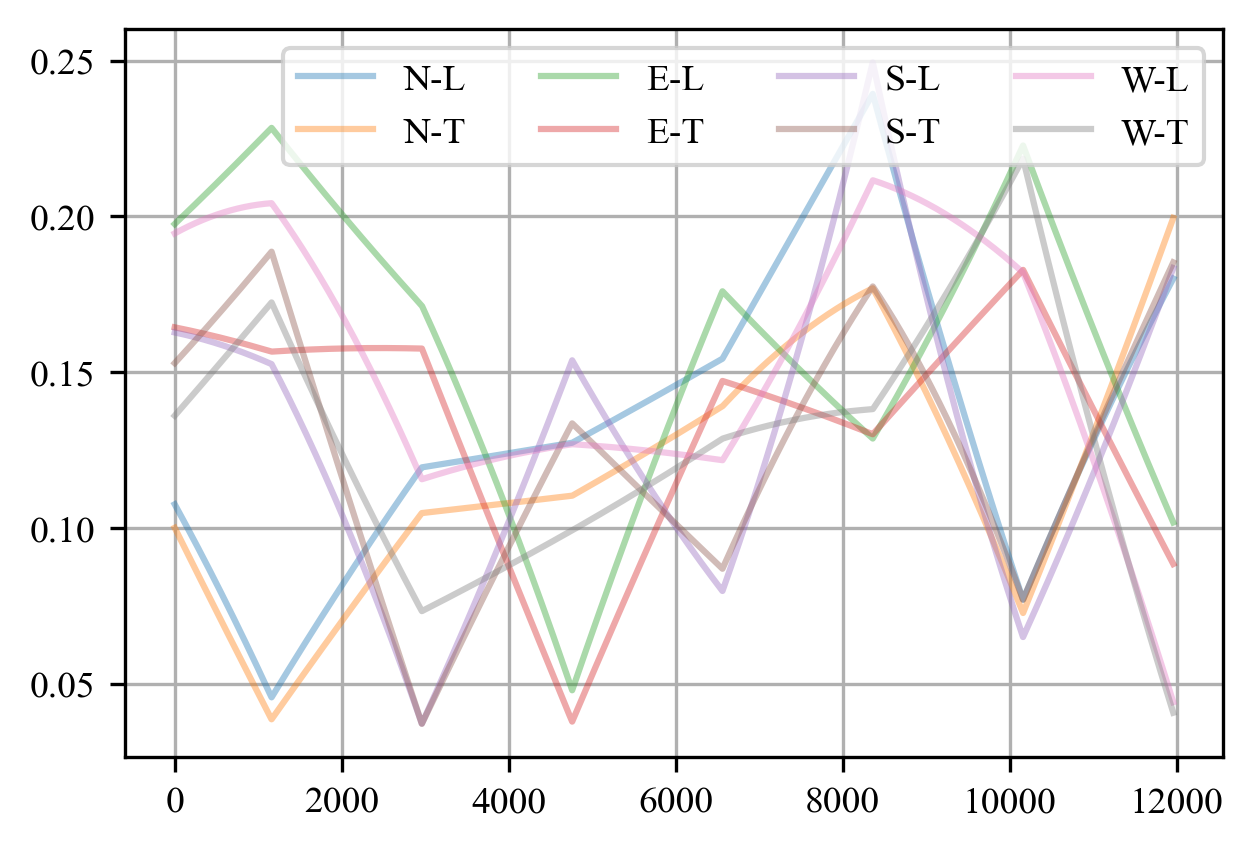

In [15]:
# 流向v-c-ratio曲线
fig,ax = plt.subplots()
for i,inlet in enumerate(['N','E','S','W']):
    for j,move in enumerate(['L','T']):
        x = mpc_data['demand'][:,i,j]
        if move=='L':
            ax.plot(x/(0.9*1880),label=f'{inlet}-{move}',alpha=0.4)
        elif move=='T':
            ax.plot(x/(2*1880),label=f'{inlet}-{move}',alpha=0.4)
ax.legend(ncol=4)

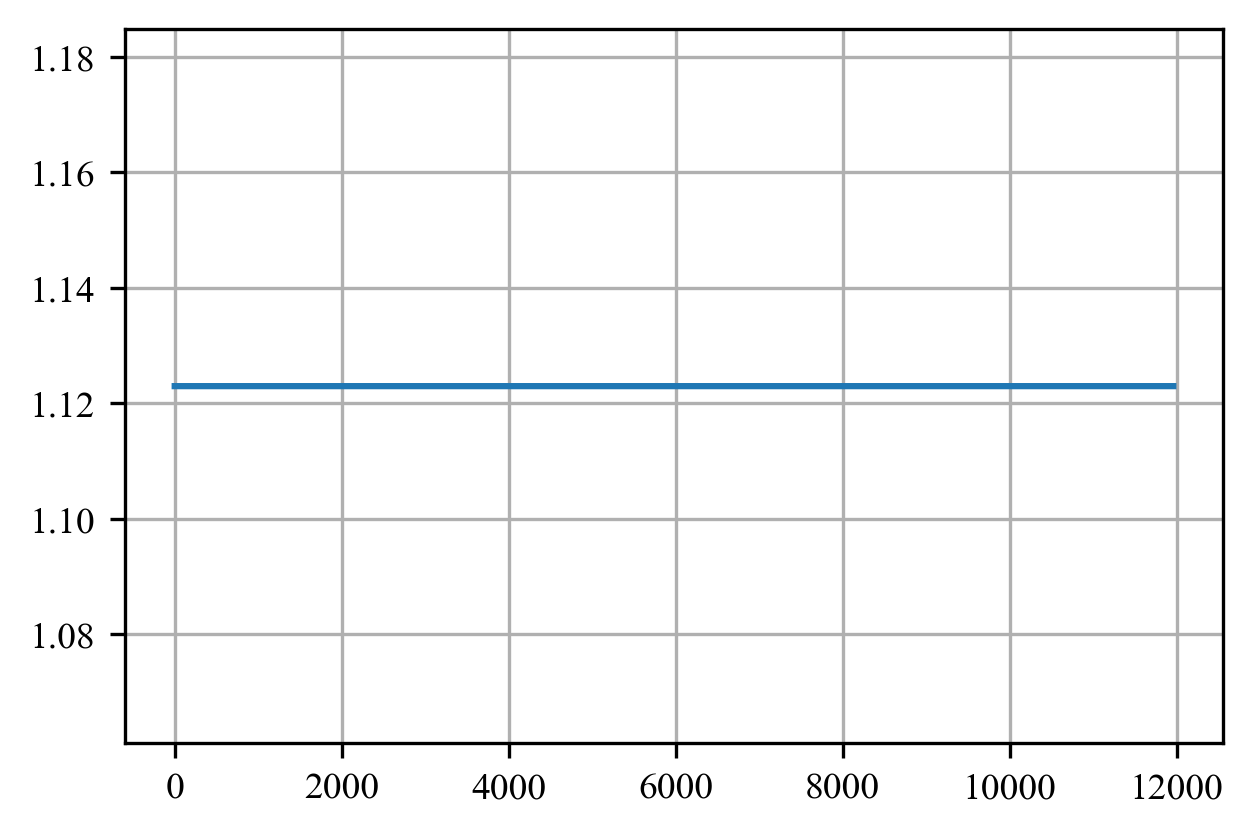

In [97]:
# v-c-ratio曲线
fig,ax = plt.subplots()
vc_r = np.zeros(len(mpc_data['demand']))
for i,inlet in enumerate(['N','E','S','W']):
    for j,move in enumerate(['L','T']):
        x = mpc_data['demand'][:,i,j]
        if j == 0:
            x = x/0.9
        elif j == 1:
            x = x/2
        vc_r += x/1880

ax.plot(vc_r,label='volume-capacity-ratio')

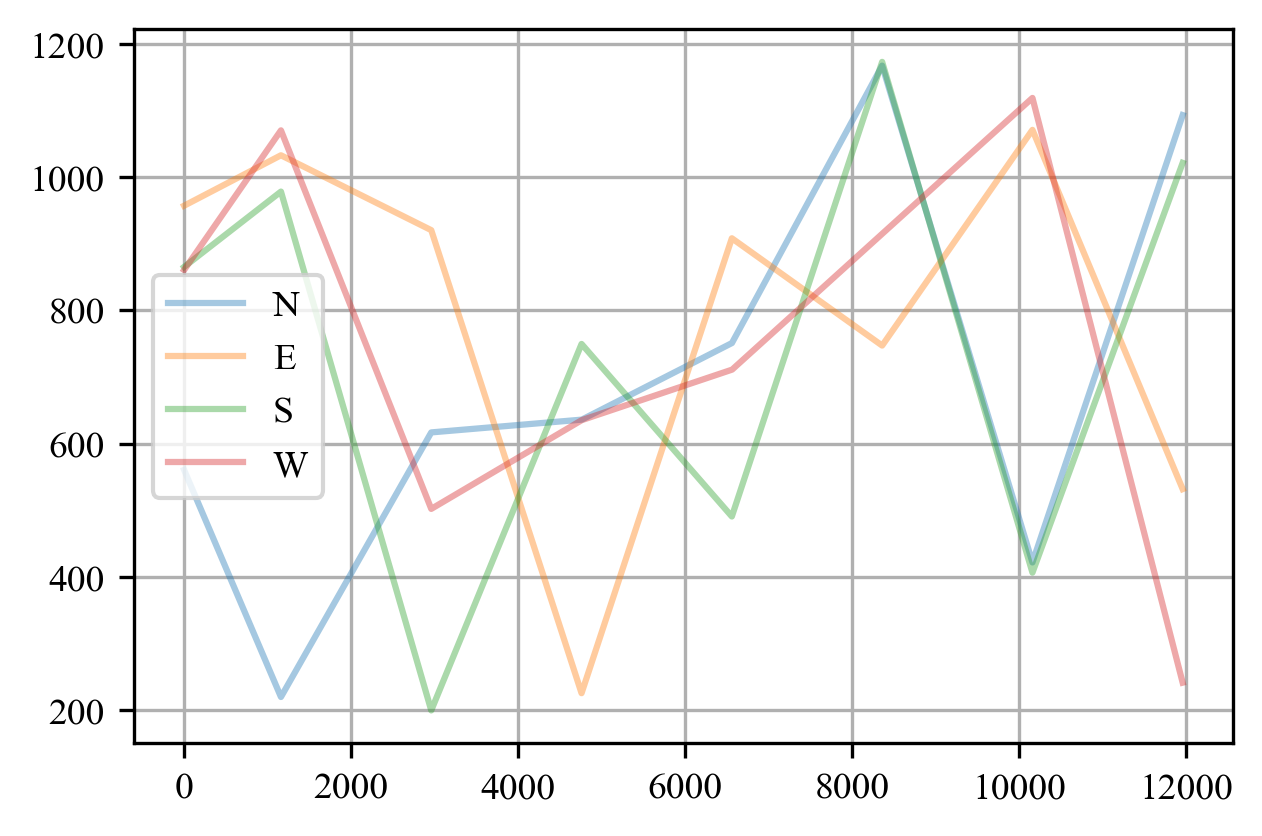

In [178]:
# 流向需求曲线
fig,ax = plt.subplots()
for i,inlet in enumerate(['N','E','S','W']):
    x = mpc_data['demand'][:,i].sum(-1)
    ax.plot(x,label=f'{inlet}',alpha=0.4)
ax.legend()

##### 代理模型分析

ValueError: x and y must have same first dimension, but have shapes (17,) and (16,)

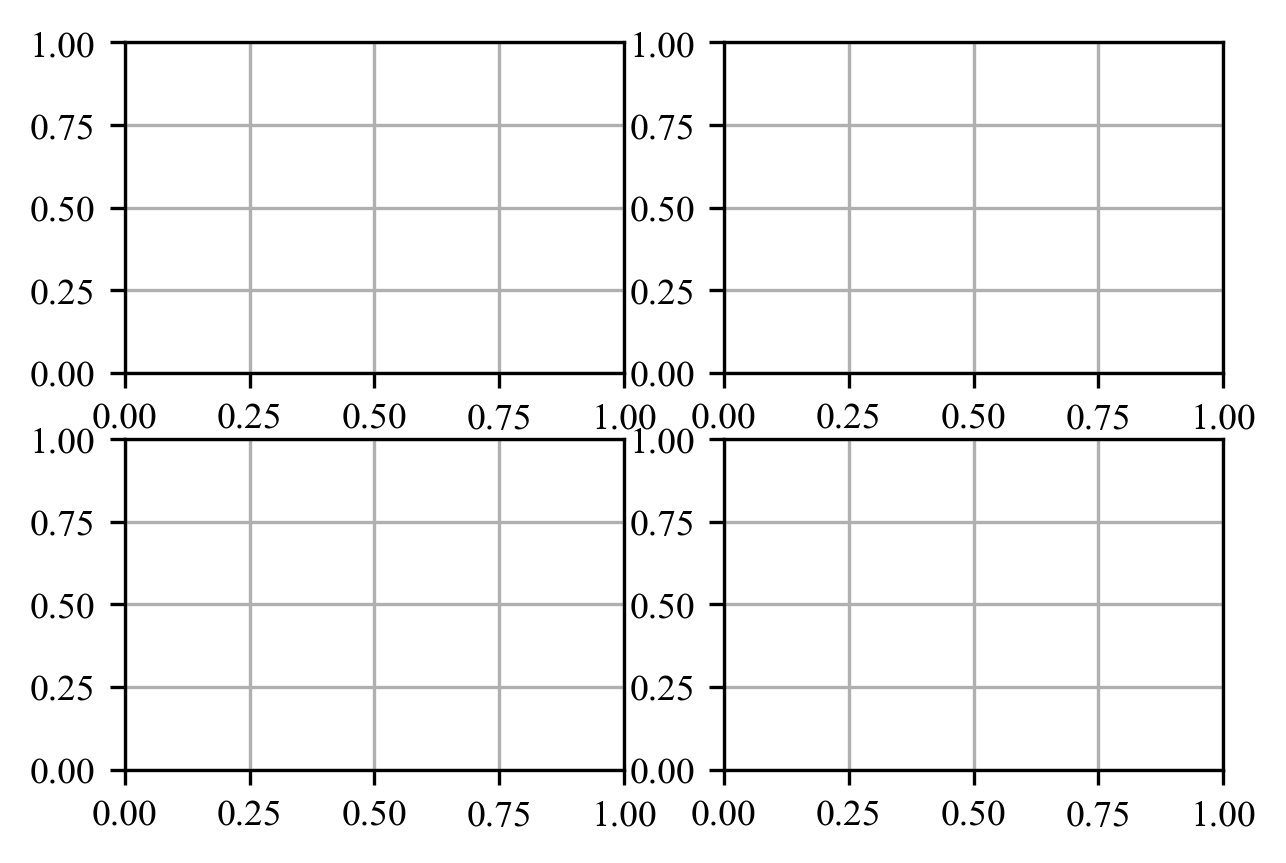

In [8]:
# 不确定性代理结果
fig,axs = plt.subplots(2,2)

def discounted(timeloss):
    # 输入各个流向各秒的timeloss
    num = timeloss.shape[0]
    weight = np.logspace(start=0,stop=num,num=num,base=0.999)
    return (timeloss.sum((-1,-2))*weight).sum()

for l in range(1):
    axs[l//2,l%2].plot(timestamp_data[7:],[discounted(res) for res in simulation_data['timeloss'][8:]],label='Truth')
    axs[l//2,l%2].plot(timestamp_data[8:],[mdn_mean(res)[l,0].item() for res in mpc_data['surrogate_result'][:-1]],label='Prediction')
    axs[l//2,l%2].fill_between(timestamp_data[8:],
                    [(mdn_mean(res)-torch.sqrt(aleatoric_uncertainty(res)))[l,0].item() for res in mpc_data['surrogate_result'][:-1]],
                    [(mdn_mean(res)+torch.sqrt(aleatoric_uncertainty(res)))[l,0].item() for res in mpc_data['surrogate_result'][:-1]],
                    alpha=0.2,label='Aleatoric Uncertainty')
    axs[l//2,l%2].fill_between(timestamp_data[8:],
                    [(mdn_mean(res)-torch.sqrt(epistemic_uncertainty(res)))[l,0].item() for res in mpc_data['surrogate_result'][:-1]],
                    [(mdn_mean(res)+torch.sqrt(epistemic_uncertainty(res)))[l,0].item() for res in mpc_data['surrogate_result'][:-1]],
                    alpha=0.2,label='Epistemic Uncertainty')
    axs[l//2,l%2].set_ylim([0,15000])

ValueError: x and y must have same first dimension, but have shapes (16,) and (0,)

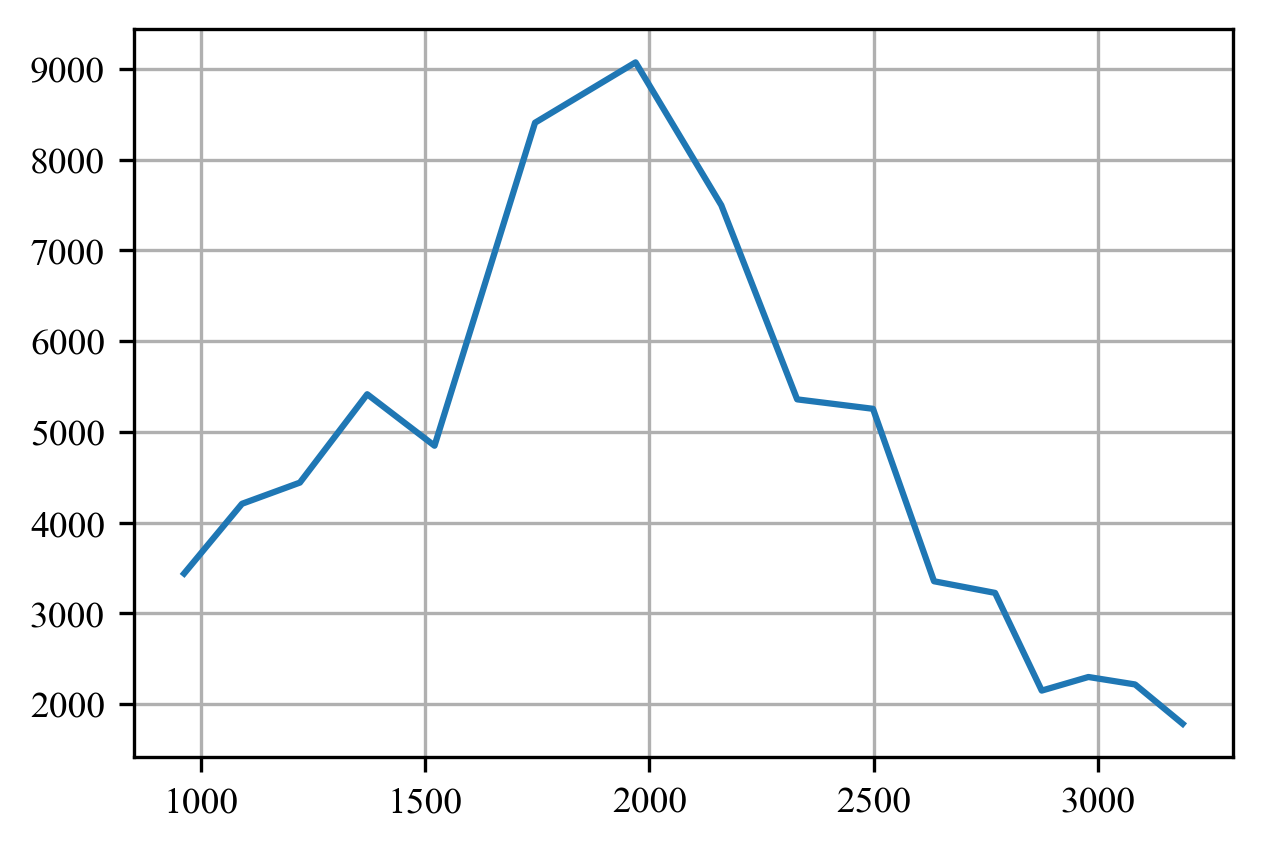

In [9]:
# 期望代理结果
fig,ax = plt.subplots()

def discounted(timeloss):
    num = timeloss.shape[0]
    weight = np.logspace(start=0,stop=num,num=num,base=0.999)
    return (timeloss.sum((-1,-2))*weight).sum()

ax.plot(timestamp_data[8:],[discounted(res) for res in simulation_data['timeloss'][8:]],label='Truth')
for l in range(1):
    ax.plot(timestamp_data[8:],[mdn_mean(res)[l,0].item() for res in mpc_data['surrogate_result'][:-1]],label=f'{l+1}-Step-Ahead')
ax.legend()

In [10]:
# 代理曲面
num = 20
cycle_index = 6
x = np.linspace(10,65,num)
phase = (2,7)

res = np.zeros((num,num))
from tqdm import tqdm
pbar = tqdm(total=num*num,desc='Processing:')
for i,x1 in enumerate(x):
    for j,x2 in enumerate(x):
        tc_temp = mpc_data['control_result'][cycle_index].clone().unsqueeze(0)
        tc_temp[0,0,5+phase[0]] = x1
        tc_temp[0,0,5+phase[1]] = x2
        with torch.no_grad():
            res[i,j] = mdn_mean(mpc_data['surrogate_model'].predict(mpc_data['context_result'][cycle_index],tc_temp))[0,0]
        pbar.update(1)

fig,ax = plt.subplots()
ax.set_aspect('equal')

X,Y = np.meshgrid(x,x)
ax.scatter(mpc_data['control_result'][cycle_index][0,5+phase[0]],mpc_data['control_result'][cycle_index][0,5+phase[1]],s=10.0,c='r',zorder=10)
contour = ax.contourf(X,Y,res,levels=30,cmap=plt.cm.jet,alpha=0.8)
cbar=fig.colorbar(contour, shrink=0.8, aspect=8,alpha=0.8,label="Objective Function Value")

Processing::   0%|          | 0/400 [00:08<?, ?it/s]

IndexError: list index out of range